In [ ]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
# Define the folder path

# Create a dictionary to store the dataframes
dataframes = {}

# Define the different Re values
re_values = [850, 900, 977, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1500, 1600,1700,1800,1900,2000]


# Loop through each Re value and read the CSV files
for re_value in re_values:  # Avoid using 're' as a variable name
    folder_path = f"/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data Global Model Re = {re_value}"
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f.startswith('dynamic_simulation')]
    
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df_name = os.path.splitext(file)[0]  # Use the file name without extension as the key
        dataframes[df_name] = pd.read_csv(file_path)
# Display the keys of the dataframes dictionary to see the imported dataframes


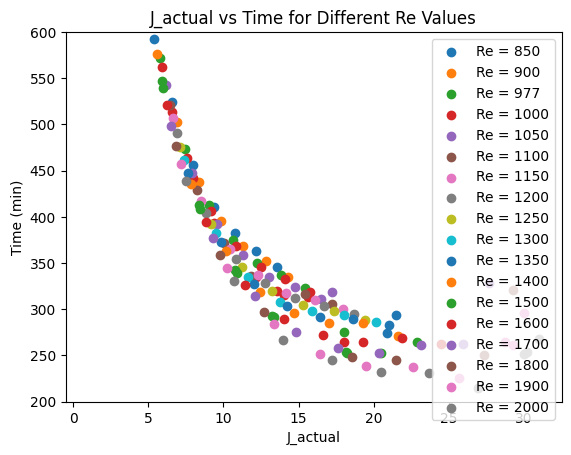

In [ ]:
import matplotlib.pyplot as plt

# Group the data by Re value
grouped_data = {}
for df_name, df in dataframes.items():
    match = re.search(r"Re(\d+)", str(df_name))
    if match:
        Re_value = int(match.group(1))
        if Re_value not in grouped_data:
            grouped_data[Re_value] = []
        J_actual_match = re.search(r"J_actual_(\d+\.\d+)", df_name)
        if J_actual_match:
            J_actual_value = float(J_actual_match.group(1))
            last_row = df.iloc[-1]
            grouped_data[Re_value].append((last_row['Time (s)'], J_actual_value))

# Create a zip with the time values and the J values for each Re group
for Re_value, data in grouped_data.items():
    data.sort()  # Sort the data by time values
    times, J_values = zip(*data)

    times = [time / 60 for time in times]
    plt.scatter(J_values, times, label=f'Re = {Re_value}')

# Add labels and title
plt.ylabel('Time (min)')
plt.xlabel('J_actual')
plt.ylim(200, 600)
plt.title('J_actual vs Time for Different Re Values')
plt.legend()
plt.show()

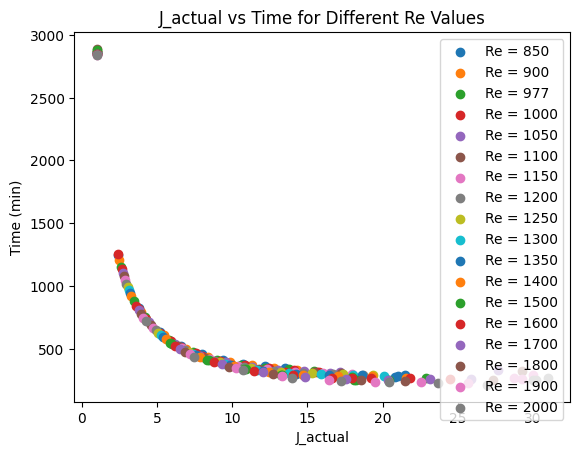

In [ ]:
import matplotlib.pyplot as plt

# Group the data by Re value
grouped_data = {}
for df_name, df in dataframes.items():
    match = re.search(r"Re(\d+)", str(df_name))
    if match:
        Re_value = int(match.group(1))
        if Re_value not in grouped_data:
            grouped_data[Re_value] = []
        J_actual_match = re.search(r"J_actual_(\d+\.\d+)", df_name)
        if J_actual_match:
            J_actual_value = float(J_actual_match.group(1))
            last_row = df.iloc[-1]
            grouped_data[Re_value].append((last_row['Time (s)'], J_actual_value))

# Create a zip with the time values and the J values for each Re group
for Re_value, data in grouped_data.items():
    data.sort()  # Sort the data by time values
    times, J_values = zip(*data)

    times = [time / 60 for time in times]
    plt.scatter(J_values, times, label=f'Re = {Re_value}')

# Add labels and title
plt.ylabel('Time (min)')
plt.xlabel('J_actual')

plt.title('J_actual vs Time for Different Re Values')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

import plotly.express as px

# Group the data by Re value
grouped_data = []
for df_name, df in dataframes.items():
    match = re.search(r"Re(\d+)", str(df_name))
    if match:
        Re_value = int(match.group(1))
        J_actual_match = re.search(r"J_actual_(\d+\.\d+)", df_name)
        if J_actual_match:
            J_actual_value = float(J_actual_match.group(1))
            last_row = df.iloc[-1]
            grouped_data.append({
                'Re': Re_value,
                'Diavolumes': last_row['Diavolumes'],
                'J_actual': J_actual_value,
                'Time': last_row['Time (s)']
            })

# Create a DataFrame from the grouped data
grouped_df = pd.DataFrame(grouped_data)

# Create the interactive scatter plot
fig = px.scatter(grouped_df, x='Diavolumes', y='J_actual', color='Re',
                 hover_data=['Re', 'Time'],
                 labels={'Diavolumes': 'Diavolumes', 'J_actual': 'J (LMH)'},
                 title='J_actual vs Diavolumes for Different Re Values')

fig.update_layout(xaxis_range=[3.8, 4.5])

fig.show()

In [ ]:
# Define the folder path


# Create a dictionary to store the dataframes
dataframes_X = {}

# Define the different Re values
x_values = [1.25,1.5,1.75,2.0]


# Loop through each Re value and read the CSV files
for x_value in x_values:  # Avoid using 're' as a variable name
    folder_path = f"/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data Global Model Re = 977 X = {x_value}"
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df_name = os.path.splitext(file)[0]  # Use the file name without extension as the key
        dataframes_X[df_name] = pd.read_csv(file_path)
    

In [ ]:
folder = f"/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data Global Model Re = 977"
csv_files_1 = [f for f in os.listdir(folder) if f.endswith('.csv')]

for file in csv_files_1:
	file_path = os.path.join(folder, file)
	df_name = os.path.splitext(file)[0] + "_Re977_X1.0"  # Use the file name without extension as the key and add the suffix
	dataframes_X[df_name] = pd.read_csv(file_path)

In [ ]:
# Group the data by X value
grouped_data_X = []
for df_name, df in dataframes_X.items():
    match = re.search(r"X(\d+\.\d+)", str(df_name))
    if match:
        X_value = float(match.group(1))
        J_actual_match = re.search(r"J_actual_(\d+\.\d+)", df_name)
        if J_actual_match:
            J_actual_value = float(J_actual_match.group(1))
            last_row = df.iloc[-1]
            if 'Diavolumes' in last_row:
                grouped_data_X.append({
                    'X': X_value,
                    'Diavolumes': last_row['Diavolumes'],
                    'J_actual': J_actual_value,
                    'Time': last_row['Time (s)']
                })

# Create a DataFrame from the grouped data
grouped_df_X = pd.DataFrame(grouped_data_X)

# Create the interactive scatter plot
fig_X = px.scatter(grouped_df_X, y=grouped_df_X['Time'] / 60, x='X', color='J_actual',
                   hover_data=['Time', 'J_actual', 'Diavolumes'],
                   labels={'Time': 'Time (min)', 'J_actual': 'J (LMH)'},
                   title='J_actual vs Time for Different X Values')

fig_X.update_layout(yaxis_range=[300, 700])

fig_X.update_layout(xaxis_range=[0, 2])

fig_X.show()


In [ ]:
# Group by 'X' and get the row with the minimum 'Time' for each group
min_time_df_X = grouped_df_X.loc[grouped_df_X.groupby('X')['Time'].idxmin()]

# Create the interactive scatter plot
fig_X_min_time = px.scatter(min_time_df_X, x='X', y=min_time_df_X['Time'] / 60, color='Diavolumes',
                            hover_data=['X', 'J_actual'],
                            labels={'Diavolumes': 'Diavolumes', 'Time': 'Time (min)', 'J_actual': 'J (LMH)'},
                            title='J_actual vs Diavolumes for Different X Values (Minimum Time)')

fig_X_min_time.update_layout(yaxis_range=[200, 450])

fig_X_min_time.show()


In [ ]:
# Define the folder path


# Create a dictionary to store the dataframes
dataframes_10_60 = {}

# Define the different Re values
X_values = [1.0,1.25,1.5,1.75,2.0]


# Loop through each Re value and read the CSV files
for X_value in X_values:  # Avoid using 're' as a variable name
    folder_path = f"/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data Global Model X"
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df_name = os.path.splitext(file)[0]  # Use the file name without extension as the key
        dataframes_10_60[df_name] = pd.read_csv(file_path)
dataframes_10_60.keys()

dict_keys(['dynamic_simulation_J_actual_10.60_Re977_X1.75', 'dynamic_simulation_J_actual_10.60_Re977_X2.25', 'dynamic_simulation_J_actual_10.60_Re977_X2.0', 'dynamic_simulation_J_actual_10.60_Re977_X1.5', 'dynamic_simulation_J_actual_10.60_Re977_X1.25', 'dynamic_simulation_J_actual_10.60_Re977_X1.0'])

folder = f"/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data Global Model Re = 2000"
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv') and f.startswith('dynamic_simulation')]
for file in csv_files:
  file_path = os.path.join(folder, file)
  df = pd.read_csv(file_path)
  df['Diavolumes'] = df['V2'] / 85e-6
  # Save the modified dataframe back to the CSV file
  df.to_csv(file_path, index=False)
    

In [ ]:
# Group the data by X value
grouped_data_10_60 = []
for df_name, df in dataframes_10_60.items():
    match = re.search(r"X(\d+\.\d+)", str(df_name))
    if match:
        X_value = float(match.group(1))
        J_actual_match = re.search(r"J_actual_(\d+\.\d+)", df_name)
        if J_actual_match:
            J_actual_value = float(J_actual_match.group(1))
            last_row = df.iloc[-1]
            time_value = last_row['Time (s)']
            if X_value > 1:
                time_value += 5310 *(X_value-1)  # Add 5310 seconds to the time
            grouped_data_10_60.append({
                'X': X_value,
                'Diavolumes': last_row['Diavolumes'],
                'J_actual': J_actual_value,
                'Time': time_value
            })

# Create a DataFrame from the grouped data
grouped_df_10_60 = pd.DataFrame(grouped_data_10_60)

# Create the interactive scatter plot
fig_X = px.scatter(grouped_df_10_60, x='X', y=(grouped_df_10_60['Time'] / 60 / grouped_df_10_60['X']), color='Diavolumes',
                   hover_data=['X', 'J_actual', 'Diavolumes'],
                   labels={'Time': 'Time (min)', 'J_actual': 'J (LMH)', 'y': 'Time/X'},
                   title='J_actual vs Time for Different X Values')

fig_X.update_layout(yaxis_title='Time/X', yaxis_range=[250, 410])

fig_X.show()


In [ ]:
folder = f"/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data V_1 = 85 Re = 977 X2.25 Perm Loop"
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv') and f.startswith('dynamic_simulation')]
for file in csv_files:
  file_path = os.path.join(folder, file)
  df = pd.read_csv(file_path)
  df['Diavolumes'] = df['V2'] / 85e-6
  # Save the modified dataframe back to the CSV file
  df.to_csv(file_path, index=False)

In [49]:
# Create a dictionary to store the dataframes
dataframes_loop = {}

# Define the different X values
x_values = [1.0, 1.25, 1.5, 1.75, 2.0,2.25]

# Loop through each X value and read the CSV files
for x_value in x_values:
    folder_path = f"/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data V_1 = 85 Re = 977 X{x_value} Perm Loop"
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f.startswith('dynamic_simulation')]
    
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df_name = os.path.splitext(file)[0]
        dataframes_loop[df_name] = pd.read_csv(file_path)

# print(dataframes_loop.keys())

# Group the data by X value
grouped_data_loop = []
for df_name, df in dataframes_loop.items():
    match = re.search(r"X(\d+\.\d+)", str(df_name))
    if match:
        X_value = float(match.group(1))
        J_actual_match = re.search(r"J_actual_(\d+\.\d+)", df_name)
        if J_actual_match:
            J_actual_value = float(J_actual_match.group(1))
            if '10nm_cumulative_yield' in df.columns:
                if df['10nm_cumulative_yield'].max() >= 0.85:
                    yield_index = df[df['10nm_cumulative_yield'] >= 0.85].index[0]
                else:
                    yield_index = df.index[-1]
                yield_index_row = df.loc[yield_index]
                grouped_data_loop.append({
                    'X': X_value,
                    'Diavolumes': yield_index_row['Diavolumes'],
                    'J_actual': J_actual_value,
                    'Time': yield_index_row['Time (s)'],
                    'Yield': yield_index_row['10nm_cumulative_yield']
                })

# Create a DataFrame from the grouped data
grouped_df_loop = pd.DataFrame(grouped_data_loop)

# Create the interactive scatter plot
fig_X = px.scatter(grouped_df_loop, y=(grouped_df_loop['Time'] / 60)/grouped_df_loop['X'], x='X', color='J_actual',
                   hover_data=['Time', 'J_actual', 'Diavolumes','Yield'],
                   labels={'Time': 'Time (min)', 'J_actual': 'J (LMH)'},
                   title='J_actual vs Time for Different X Values')

fig_X.update_layout(xaxis_range=[0.8, 2.3])
fig_X.update_layout(yaxis_range=[200, 410])

fig_X.show()

    

In [36]:
grouped_data_loop = []
for df_name, df in dataframes_loop.items():
    match = re.search(r"X(\d+\.\d+)", str(df_name))
    if match:
        X_value = float(match.group(1))
        J_actual_match = re.search(r"J_actual_(\d+\.\d+)", df_name)
        if J_actual_match:
            J_actual_value = float(J_actual_match.group(1))
            if '10nm_cumulative_yield' in df.columns:
                if df['10nm_cumulative_yield'].max() >= 0.85:
                    yield_index = df[df['10nm_cumulative_yield'] >= 0.85].index[0]
                else:
                    yield_index = df.index[-1]
                yield_index_row = df.loc[yield_index]
                grouped_data_loop.append({
                    'X': X_value,
                    'Diavolumes': yield_index_row['Diavolumes'],
                    'J_actual': J_actual_value,
                    'Time': yield_index_row['Time (s)'],
                    'Yield': yield_index_row['10nm_cumulative_yield']
                })

# Create a DataFrame from the grouped data
grouped_df_loop = pd.DataFrame(grouped_data_loop)

# Create the interactive scatter plot
fig_X = px.scatter(grouped_df_loop, y=grouped_df_loop['Time'] / 60, x='J_actual', color='X',
                   hover_data=['Time', 'J_actual', 'Diavolumes','Yield'],
                   labels={'Time': 'Time (min)', 'J_actual': 'J (LMH)'},
                   title='J_actual vs Time for Different X Values')

fig_X.update_layout(xaxis_range=[4, 15])
fig_X.update_layout(yaxis_range=[350, 600])

fig_X.show()